# Analysing how demographics affects school perfomance in NYC

The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year.  The SAT has three sections, each of which is worth a maximum of 800 points.  Colleges use the SAT to determine which students to admit.  High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets.  New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores will help us identify which demographic groups tend to do better on the SAT.

### Imports and reading in data

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import re

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 60

# Plotting
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Create dictionary to store data and make it easier to reference
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in surveys

In [4]:
# Read in surveys data
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort="False")

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]

# Add survey data to our dictionary of other data
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

# Convert SAT score columns to numeric, attempt to coerce into correct form if errors met along the way
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# Create total SAT score column
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Define helper functions to get latitude and longitude of schools - will use to map out the schools later on
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Retreive latitudes and longitudes and create new columns to store them 
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Convert to numeric
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation
survey_fields.remove("DBN")

Several fields in the combined dataframe have come from a survey of parents, teachers and students.  These fields are those contained in the survey_fields list.  Let's plot a bar chart to see how these variables correlate with sat_score.

<BarContainer object of 22 artists>

[Text(0, 0, 'rr_s'),
 Text(0, 0, 'rr_t'),
 Text(0, 0, 'rr_p'),
 Text(0, 0, 'N_s'),
 Text(0, 0, 'N_t'),
 Text(0, 0, 'N_p'),
 Text(0, 0, 'saf_p_11'),
 Text(0, 0, 'com_p_11'),
 Text(0, 0, 'eng_p_11'),
 Text(0, 0, 'aca_p_11'),
 Text(0, 0, 'saf_t_11'),
 Text(0, 0, 'com_t_11'),
 Text(0, 0, 'eng_t_11'),
 Text(0, 0, 'aca_t_11'),
 Text(0, 0, 'saf_s_11'),
 Text(0, 0, 'com_s_11'),
 Text(0, 0, 'eng_s_11'),
 Text(0, 0, 'aca_s_11'),
 Text(0, 0, 'saf_tot_11'),
 Text(0, 0, 'com_tot_11'),
 Text(0, 0, 'eng_tot_11'),
 Text(0, 0, 'aca_tot_11')]

Text(-2, 0.5, 'Correlations between survey\nresponse variables and SAT scores')

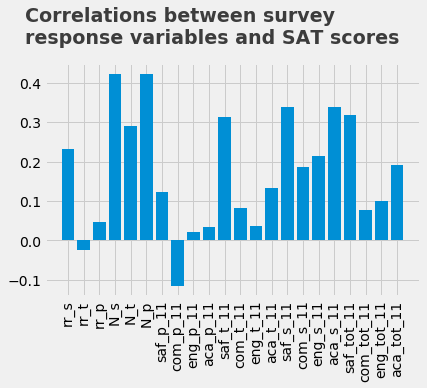

In [13]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(22)+0.75)

ax.bar(np.arange(22)+0.75, correlations[survey_fields])

ax.set_xticklabels(survey_fields, rotation=90)

ax.text(x = -2, y = 0.5, s = "Correlations between survey\nresponse variables and SAT scores",
               fontsize = 19, weight = 'bold', alpha = .75)


We can see the strongest positive correlations with SAT scores from N_s, N_p, saf_t_11, saf_s_11, aca_s_11 and saf_tot_11, which all have correlation coefficients over 0.3.  We should also remark that none of these correlations are particularly strong and we would have to perform hypothesis tests before we could say that we have evidence to suggest any positive correlations actually exist.

Consulting our data dictionary:

- N_s:  Number of student respondents
- N_p:  Number of parent respondents
- saf_t_11:  Safety and Respect score based on teacher responses
- saf_s_11:  Safety and Respect score based on student responses
- aca_s_11:  Academic expectations score based on student responses
- saf_tot_11:  Safety and Respect total score

If we assume that each school has a similar response rate to the survey, then a higher number of responses from students and parents should indicate a larger school.  If this assumption is correct, then it could be argued that the data shows that larger schools tend to do better in terms of SAT scores - since there are positive correlations between SAT scores and N_s and N_p.

The data would also suggest that schools that score higher in the Safety and Respect category (whatever that refers to) tend to achieve better SAT scores as well.  There is also an indication that schools whose students rated them highly on Academic Expectations also had higher SAT scores.

However, it is worth reiterating - all the correlations described above are weak and would need further investigation to ascertain whether they are statistically significantlly different from zero at a reasonable level.

# Investigation of safety level correlation

Let's investigate the correlation between saf_s_11 (how students rate the safety level of the school) and sat_score in more detail. 

Text(0.5, 0, 'Safety score')

Text(0, 0.5, 'Total average SAT score')

Text(4.3, 2250, 'Student-rated safety score vs SAT\nscores for 363 NYC schools')

Text(4, 530, '___________________________________________________________________')

Text(4, 430, '© ANDREW HETHERINGTON   Source: National Center for Education Statistics   ')

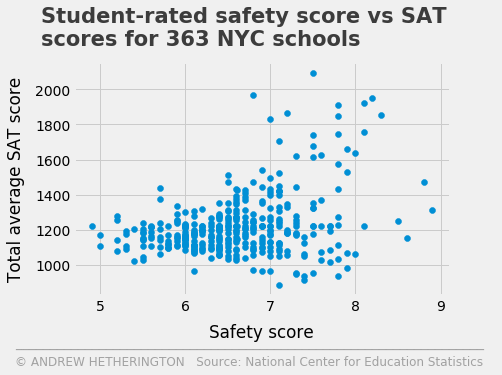

In [14]:
fig, ax = plt.subplots()

ax.scatter(combined["saf_s_11"], combined["sat_score"])

ax.set_xlabel("Safety score", labelpad=10)

ax.set_ylabel("Total average SAT score", labelpad=10)

ax.text(x = 4.3, y = 2250, s = "Student-rated safety score vs SAT\nscores for 363 NYC schools",
               fontsize = 21, weight = 'bold', alpha = .75)

ax.text(x = 4, y = 530,
    s = '___________________________________________________________________',
    color = 'grey', alpha = .7)

ax.text(x = 4, y = 430,
    s = 'Source: National Center for Education Statistics   ',
    fontsize = 12, color = 'grey', alpha = .7)

Now, let's map out the safety scores by district.  Let's take the average safety scores by district and then plot them out on a map of New York City.

C:\Users\Andrew\Anaconda3\envs\dataquest\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=913122.7552667909,120102.74479508692,1067090.3211193548,272872.4944441424&bboxSR=2263&imageSR=2263&size=3000,2976&dpi=96&format=png32&transparent=true&f=image


Text(0, -0.02, '______________________________________________________________________________________')

Text(0, -0.06, 'Source: National Center for Education Statistics   ')

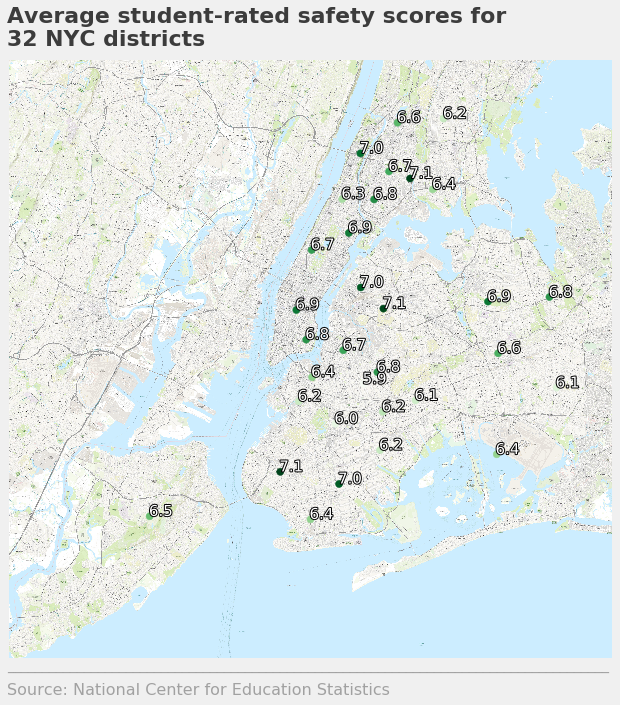

In [25]:
districts = combined.groupby("school_dist").agg(np.mean)

import os
os.environ['PROJ_LIB'] = "C:/Users/Andrew/Anaconda3/envs/dataquest/Lib/site-packages/mpl_toolkits/basemap/data"
from mpl_toolkits.basemap import Basemap

import matplotlib.patheffects as path_effects

fig, ax = plt.subplots(figsize=(20,10))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i',
    epsg=2263
)

# m.drawmapboundary(fill_color='#85A6D9')
# m.drawcoastlines(color='#6D5F47', linewidth=.4)
# m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c= districts["saf_s_11"], cmap="Greens")

m.arcgisimage(service='World_Topo_Map', xpixels = 3000, verbose= True)

# Plot safety scores

def convert_to_plot_frac(x, y):
    return (x - -74.255735)/(-73.700272--74.255735), (y - 40.496044)/(40.915256-40.496044)

for d in districts.iterrows():
    text = ax.annotate(str(round(d[1][49],1)), xy=(convert_to_plot_frac(d[1][66], d[1][65])), xytext=(convert_to_plot_frac(d[1][66], d[1][65])),
                xycoords="axes fraction", textcoords="axes fraction", size=15, c="white")
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])

# text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
#                        path_effects.Normal()])
    
t1 = ax.text(x = 0, y = 1.02, s = "Average student-rated safety scores for\n32 NYC districts",
               fontsize = 22, weight = 'bold', alpha = .75, transform=ax.transAxes, c="black")

ax.text(x = 0, y = -0.02,
    s = '______________________________________________________________________________________',
    color = 'grey', alpha = .7, transform=ax.transAxes)

ax.text(x = 0, y = -0.06,
    s = 'Source: National Center for Education Statistics   ',
    fontsize = 16, color = 'grey', alpha = .7, transform=ax.transAxes)

plt.tight_layout()

plt.savefig('test.png', dpi=500)

plt.show()

Now that we've mapped out safety scores by district, let's move on to something else.

# Racial correlation with SAT scores

Let's plot out the correlations between the following variables and sat_score, since these represent the demographic makeup of the various schools in our data:

- white_per
- asian_per
- black_per
- hispanic_per

In [14]:
racial_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]

correlations[racial_fields]

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

At first glance, it looks like there are potentially some positive correlations between SAT scores the percentage of students who are white and asian, and negative correlations between SAT scores and the percentage of students who are black and hispanic.  

The correlation coefficients for the white and asian proportions seem to be relatively high (both around +0.6), while those for black and hispanic proportions are closer to zero (both smaller than -0.4, in the sense they are closer to zero).  

However, we should remember that before we can come to any reasonable conclusions, we would need to perform further statistical analysis on these correlation coefficients in order to say with confidence that they are significantly different from zero (ie that there is a correlation).

With this precaution in mind, let's plot a bar graph of these correlations.

NameError: name 'racial_fields' is not defined

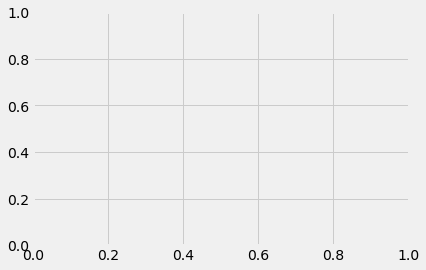

In [18]:
fig, ax = plt.subplots()

ax.bar(np.arange(4) + 0.75, correlations[racial_fields])

ax.set_xlabel("Demographic group", labelpad=10)

ax.set_ylabel("Correlation coefficient", labelpad=10)

ax.set_xticks(np.arange(4)+0.75)

labels = ["White", "Asian", "Black", "Hispanic"]

ax.set_xticklabels(labels)

ax.text(x = -0.2, y = 0.75, s = "Correlation between SAT scores and racial group",
               fontsize = 21, weight = 'bold', alpha = .75)

ax.text(x = -0.6, y = -0.7,
    s = '___________________________________________________________________',
    color = 'grey', alpha = .7)

ax.text(x = -0.6, y = -0.8,
    s = 'Source: National Center for Education Statistics   ',
    fontsize = 12, color = 'grey', alpha = .7)

# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['left'].set_smart_bounds(True)
# ax.spines['bottom'].set_smart_bounds(True)

# Make the zero line more visible so it's easier to distinguish positive vs negative values
plt.axhline(y=0, xmin=0, xmax=1, color="k", linewidth=1)

plt.show()

Let's take a closer look at the relationship between hispanic_per and sat_score by creating a scatter graph.

Text(0.5, 0, '%')

Text(-10, 2250, 'Average SAT score vs\npercentage of Hispanic students')

Text(-15, 500, '___________________________________________________________________')

Text(-15, 400, '© ANDREW HETHERINGTON   Source: National Center for Education Statistics   ')

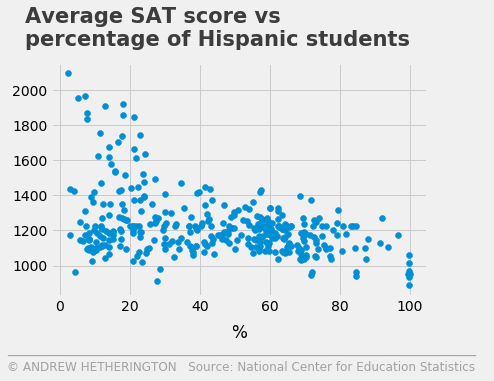

In [16]:
fig, ax = plt.subplots()

ax.scatter(combined["hispanic_per"], combined["sat_score"])

ax.set_xlabel("%", labelpad=10)

ax.text(x = -10, y = 2250, s = "Average SAT score vs\npercentage of Hispanic students",
               fontsize = 21, weight = 'bold', alpha = .75)

ax.text(x = -15, y = 500,
    s = '___________________________________________________________________',
    color = 'grey', alpha = .7)

ax.text(x = -15, y = 400,
    s = 'Source: National Center for Education Statistics   ',
    fontsize = 12, color = 'grey', alpha = .7)

We can see that for the majority of the data, there does not seem to be any link between the two varialbes.  However, there are a relatively small number of school with low proportions of Hispanic students who tend to score very highly on the SAT, as well as a number of school which are totally made up of Hispanic students that score particularly low on the SAT.  The presence of these groups will be what is influencing the correlation coefficient are bringing in down and away from zero. 

Let's do some of our own research into the schools with particularly high and low values for hispanic_per.  These schools are:

In [17]:
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

A lot of these are international schools or multipcultural schools, which explains their high proportion of Hispanic students.  For example, the PAN AMERICAN INTERNATIONAL HIGH SCHOOL consists entirely of Spanish-speaking students who have all been in the US for less than 4 years.  It would be interesting to see how the SAT scores break down across the three subjects to see whether there are any scores on which these students tend to score particularly poorly. 

In [18]:
subjects = ["sat_score", "SAT Critical Reading Avg. Score", "SAT Math Avg. Score", "SAT Writing Avg. Score"]
combined[combined["SCHOOL NAME"] == "PAN AMERICAN INTERNATIONAL HIGH SCHOOL"][racial_fields]
combined[combined["SCHOOL NAME"] == "PAN AMERICAN INTERNATIONAL HIGH SCHOOL"][subjects]

,white_per,asian_per,black_per,hispanic_per
286,0.0,0.0,0.0,100.0


,sat_score,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
286,951.0,317.0,323.0,311.0


We can observe that there are no subjects which the students at this school tend to score especially poorly on.

In [19]:
combined[combined["hispanic_per"] < 5]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
331    PATHWAYS COLLEGE PREPARATORY SCHOOL: A COLLEGE...
Name: SCHOOL NAME, dtype: object

Picking and researching one of these schools, the MEDGAR EVERS COLLEGE PREPARATORY SCHOOL, yields the following demographics:

### Race / Ethnicity
- White: 8
- Hispanic / Latino: 60
- Black: 1,080
- Asian: 23
- Native American: 19
- Hawaiian / Pacific Islander: 12
- Mixed: 21
- Not Specified: Not Applicable

Source: https://www.realtyhop.com/schools/k12/ny/brooklyn/medgar-evers-college-preparatory-school-11225

In [20]:
combined[combined["SCHOOL NAME"] == "MEDGAR EVERS COLLEGE PREPARATORY SCHOOL"][racial_fields]
combined[combined["SCHOOL NAME"] == "MEDGAR EVERS COLLEGE PREPARATORY SCHOOL"][subjects]

,white_per,asian_per,black_per,hispanic_per
235,0.0,0.9,95.7,2.8


,sat_score,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
235,1436.0,476.0,481.0,479.0


The data we have is consistent with our internet research.  We can observe that this school appears to have a relatively high average SAT score when compared to the other schools in the region.

But what about those outliers with exceptionally high SAT scores and very low proportions of Hispanic students?

In [21]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Quickly researching STUYVESANT HIGH SCHOOL, we can find an article from the New York times explaining that this is an extremely selective school where the majority of students are of Asian ethnicity.  Very few Hispaninc students are admitted.

Although the article linked above mainly focuses on the low proportion of Black students at these high schools, we can also observe that the same arguments could be made for Hispanic students.  Let's compare the above proprtions to the proportions in the total number of children in the NYC high school system:

_There are 1,126,501 students in the NYC school system, the largest school district in the United States. Of those students:_

- 13.2 percent of students are English Language Learners
- 20.2 percent are students with disabilities
- 72.8 percent are economically disadvantaged
- Race or ethnicity:
- 40.6 percent Hispanic
- 25.5 percent black
- 16.2 percent Asian
- 15.1 percent white
- 119,551 are in charter schools

Source: https://www.schools.nyc.gov/about-us/reports/doe-data-at-a-glance

So the comparison to make is with the proportion of Hispanic students in the high school system as a whole: 40.6%.  All other things equal, we would expect the typical school to have something close to these proprtions in terms of student demographics.  This is not what we observe for the schools above.  Although we have not done any detailed statistical analysis to quantify how confident we are in stating that there is a statistically significant difference in these schools' demographics (and in particular, we have no basis to make assertions about why this may be the case) but there definitely seems to be a major discrepancy.

Next, let's look at how the proportion of male and female students correlates with the SAT scores in our data.

<BarContainer object of 2 artists>

Text(0.5, 0, 'Proportion of students')

Text(0, 0.5, 'Correlation coefficient')

[Text(0, 0, 'Male'), Text(0, 0, 'Female')]

Text(0.7, 0.15, 'Correlation between sex and SAT score')

Text(0.7, -0.2, '___________________________________________________________________')

Text(0.7, -0.23, '© ANDREW HETHERINGTON   Source: National Center for Education Statistics   ')

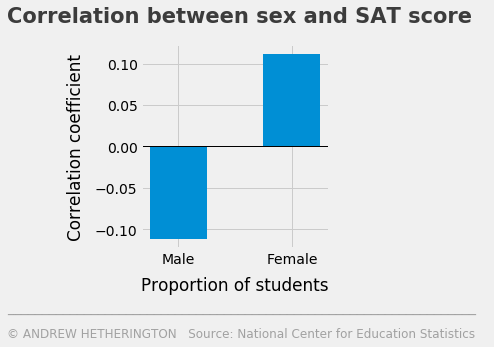

In [49]:
sex_fields = ["male_per", "female_per"]

fig, ax = plt.subplots(figsize=(3,3.5))

ax.bar([1,1.2], correlations[sex_fields], width=0.1)

ax.set_xlabel("Proportion of students", labelpad=10)

ax.set_ylabel("Correlation coefficient", labelpad=10)

ax.set_xticks([1,1.2])

labels = ["Male", "Female"]

ax.set_xticklabels(labels)

ax.text(x = 0.7, y = 0.15, s = "Correlation between sex and SAT score",
               fontsize = 21, weight = 'bold', alpha = .75)

ax.text(x = 0.7, y = -0.2,
    s = '___________________________________________________________________',
    color = 'grey', alpha = .7)

ax.text(x = 0.7, y = -0.23,
    s = 'Source: National Center for Education Statistics   ',
    fontsize = 12, color = 'grey', alpha = .7)

# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['left'].set_smart_bounds(True)
# ax.spines['bottom'].set_smart_bounds(True)

# Make the zero line more visible so it's easier to distinguish positive vs negative values
plt.axhline(y=0, xmin=0, xmax=1, color="k", linewidth=1)

plt.show()

Text(0.5, 0, '%')

Text(-10, 2250, 'Average SAT score vs\npercentage of Male students')

Text(-15, 500, '___________________________________________________________________')

Text(-15, 400, '© ANDREW HETHERINGTON   Source: National Center for Education Statistics   ')

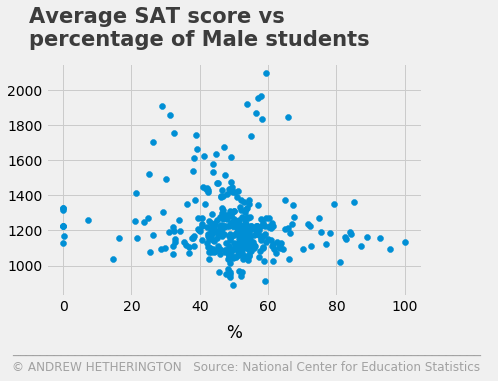

In [50]:
fig, ax = plt.subplots()

ax.scatter(combined["male_per"], combined["sat_score"])

ax.set_xlabel("%", labelpad=10)

# ax.set_ylabel("Average SAT score", labelpad=10)

ax.text(x = -10, y = 2250, s = "Average SAT score vs\npercentage of Male students",
               fontsize = 21, weight = 'bold', alpha = .75)

ax.text(x = -15, y = 500,
    s = '___________________________________________________________________',
    color = 'grey', alpha = .7)

ax.text(x = -15, y = 400,
    s = 'Source: National Center for Education Statistics   ',
    fontsize = 12, color = 'grey', alpha = .7)

Text(0.5, 0, '%')

Text(-10, 2250, 'Average SAT score vs\npercentage of Female students')

Text(-15, 500, '___________________________________________________________________')

Text(-15, 400, '© ANDREW HETHERINGTON   Source: National Center for Education Statistics   ')

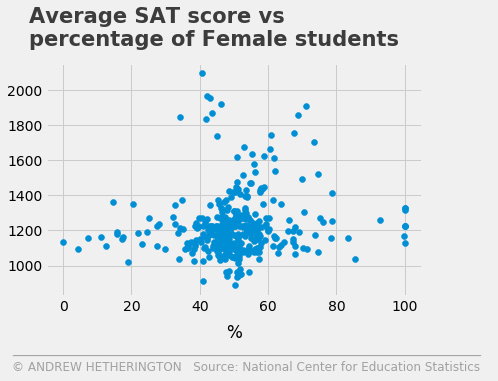

In [51]:
fig, ax = plt.subplots()

ax.scatter(combined["female_per"], combined["sat_score"])

ax.set_xlabel("%", labelpad=10)

# ax.set_ylabel("Average SAT score", labelpad=10)

ax.text(x = -10, y = 2250, s = "Average SAT score vs\npercentage of Female students",
               fontsize = 21, weight = 'bold', alpha = .75)

ax.text(x = -15, y = 500,
    s = '___________________________________________________________________',
    color = 'grey', alpha = .7)

ax.text(x = -15, y = 400,
    s = 'Source: National Center for Education Statistics   ',
    fontsize = 12, color = 'grey', alpha = .7)

There is essentially no correlation between the proportion of male or female students and SAT scores - this is evidenced by the correlation coefficients being close to zero.  Furthermore, we can see that there are no visual trends in the scatter plots for all the schools in the dataset.

Let's investigate the schools with high SAT scores and a high proportion of female students, which for the purposes of our analysis, we will define as having a female proportion greater than 60% with an average SAT score of over 1700.

In [52]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,...,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,153.45,Total Cohort,BARD HIGH SCHOOL EARLY COLLEGE,2006,139.0,134,96.4%,134,96.4%,100%,0,0%,0%,134,96.4%,...,0,0,New York Academy of Sciences,0,Student Summer Orientation,9:00 AM,3:50 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,169.00,Total Cohort,ELEANOR ROOSEVELT HIGH SCHOOL,2006,127.0,127,100%,126,99.2%,99.2%,110,86.6%,86.6%,16,12.6%,...,0,0,Virtual High School - PTA-funded online enrich...,0,Community Service Requirement,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to District 2 students or residents,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,140.00,Total Cohort,BEACON HIGH SCHOOL,2006,269.0,259,96.3%,247,91.8%,95.4%,0,0%,0%,247,91.8%,...,0,0,0,Chancellor’s Arts Endorsed Diploma,"Community Service Requirement, Our school requ...",8:00 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,790.00,Total Cohort,FIORELLO H. LAGUARDIA HIGH SCHOOL OF,2006,646.0,627,97.1%,621,96.1%,99%,324,50.2%,51.7%,297,46%,...,"Sony Music, Warner Music Group, Capital Cities...",0,0,Chancellor’s Arts Endorsed Diploma,0,8:00 AM,4:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,6,Open to New York City residents,Admission is based on the outcome of a competi...,Students must audition for each program (studi...,Students must be residents of New York City at...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,625.00,Total Cohort,TOWNSEND HARRIS HIGH SCHOOL,2006,278.0,278,100%,278,100%,100%,271,97.5%,97.5%,7,2.5%,...,"Bloomberg LLP, Con Edison, Intel",0,Townsend Harris Alumni Association,Townsend Harris students take 8 academic subje...,Community Service Requirement,8:20 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


Investigating the BARD HIGH SCHOOL EARLY COLLEGE, we can see that students are allowed to finish their high school studies early and to take college-level classes such that they can earn credit and even leave with an associate's degree in arts.  This model would explain why the school tend to have very high SAT scores.

In [53]:
combined[(combined["SCHOOL NAME"]  == "ELEANOR ROOSEVELT HIGH SCHOOL")]["female_per"]

26    67.5
Name: female_per, dtype: float64

However, we can also see that the percentage of female students isn't extremely high.  With such a large number of schools in our dataset, even if we would expect the average ratio of boys to girls to be around 1:1, it is not too surprising that there is a natural variation in the proportions.

Let's now investigate how the proportion of students who took Advanced Placement (AP) exams to earn college credit relates to the avarage SAT score.  We would expect students who take their education seriously and are working hard to achieve good good grades to do well on thier SATs and also to consider taking AP classes to prepare them for leaving high school and attending college.

If we just looked at the absolute number of students taking AP classes, then we would in fact be biasing our analysis since the total number of students enrolled in a school is already correlated with SAT scores:

In [54]:
correlations["total_enrollment"]

0.36785691698802886

This correlation isn't huge, but it's worth trying to work around.  Hence we will use the proportion of students taking AP classes instead.

In [58]:
combined["ap_per"] = combined["AP Test Takers "] * 100 / combined["total_enrollment"]
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,...,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,153.45,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,...,0,United Nations,0,0,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,30.575556
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,10.00,Total Cohort,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124.0,53,42.7%,42,33.9%,79.2%,8,6.5%,15.1%,34,27.4%,...,0,Movement Research,Incoming students are expected to attend schoo...,"Community Service Requirement, Dress Code Requ...",8:15 AM,3:15 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,3,Open to New York City residents,For M35B only: Open only to students whose hom...,0,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,9.898477
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,153.45,Total Cohort,EAST SIDE COMMUNITY SCHOOL,2006,90.0,70,77.8%,67,74.400000000000006%,95.7%,0,0%,0%,67,74.400000000000006%,...,0,Brooklyn Boulders (Rock Climbing),Students present and defend their work to comm...,Our school requires an Academic Portfolio for ...,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,1,Priority to continuing 8th graders,Then to New York City residents,0,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,3.177258
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,153.45,Total Cohort,MARTA VALLE HIGH SCHOOL,2006,84.0,47,56%,40,47.6%,85.1%,17,20.2%,36.200000000000003%,23,27.4%,...,Bank of America,"CASALEAP, Beacon","Students Dress for Success, Summer Bridge to S...","Community Service Requirement, Extended Day Pr...",8:00 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to District 1 students or residents,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,35.157724
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,191.00,Total Cohort,NEW EXPLORATIONS INTO SCIENCE TECHNO,2006,46.0,46,100%,46,100%,100%,31,67.400000000000006%,67.400000000000006%,15,32.6%,...,0,0,Dress Code Required: Business Casual - shirt/b...,0,8:15 AM,4:00 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,1,Priority to continuing 8th graders,Then to New York City residents,0,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,15.80905

Weirdly enough, some of the student numbers in the data are not integers (eg the high school in the top row has 129.028846 AP Test Takers).  If this concerned us, we would look this up in the data dictionary to try and find out why this could be the case - but for now, let's just continue.

Text(0.5, 0, '%')

Text(-5, 2250, 'Average SAT score vs percentage\nof students taking AP classes')

Text(-15, 500, '___________________________________________________________________')

Text(-15, 400, '© ANDREW HETHERINGTON   Source: National Center for Education Statistics   ')

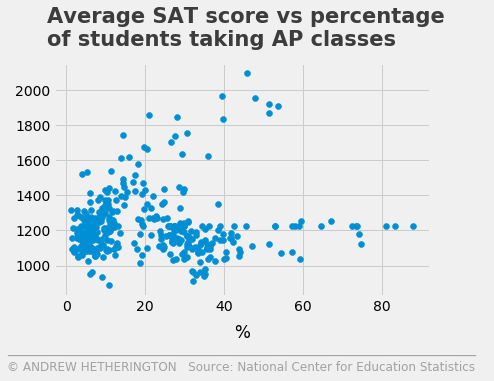

In [63]:
fig, ax = plt.subplots()

ax.scatter(combined["ap_per"], combined["sat_score"])

ax.set_xlabel("%", labelpad=10)

# ax.set_ylabel("Average SAT score", labelpad=10)

ax.text(x = -5, y = 2250, s = "Average SAT score vs percentage\nof students taking AP classes",
               fontsize = 21, weight = 'bold', alpha = .75)

ax.text(x = -15, y = 500,
    s = '___________________________________________________________________',
    color = 'grey', alpha = .7)

ax.text(x = -15, y = 400,
    s = 'Source: National Center for Education Statistics   ',
    fontsize = 12, color = 'grey', alpha = .7)

In [64]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations["ap_per"]

0.057170813907669635

Interestingly enough, there's effectively no correlation between SAT scores and the percentage of students taking AP classes in our data.  This is evidenced by the correlation coefficient being very close to zero and by the lack of pattern in the scattter graph above.

# Conclusions

We investigated the SAT scores of various New York City schools and what factors corrlated with them.  We found:

- Proportion of male and female students does not correlate with average SAT scores
- Proportion of students taking AP classes does not correlate with average SAT scores
- There may be evidence to suggest that racial demographics correlate with SAT scores, although more rigourous statistical analysis is needed to make conclusions
- Using the results of a student/parent/teacher survey, the variables that correlate most strongly with SAT scores are:
    - number of repondents (potentially a proxy for school size, depending on how uniform response rates are across our schools - further investigation needed);
    - a score measuring the safety and respect within the school; and
    - a score measuring the academic expectations of students.